<h1> Imports

In [1]:
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt 
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFdr
from scipy.signal import butter, lfilter, filtfilt, freqz
from scipy import signal
import pywt

<h1> Fitlering and Data Load Functions

In [2]:
def apply_butterband_filter(input_df):
    df = input_df.copy()
    for col in df.columns:
        df[col] = filter_df_col(df, col)
        
    return df

def filter_df_col(df, col):
    fs = 512.0
    lowcut = 12.0
    highcut = 25.0
    
    vals = df[col].values
    return butter_bandpass_filter(vals, lowcut, highcut, fs)

def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a


def butter_bandpass_filter(data, lowcut, highcut, fs, order=3):
    b, a = butter_bandpass(lowcut, highcut, fs, order=order)
    data = data * 50    # amplify data
    y = filtfilt(b, a, data)
    return y

In [3]:
def wavelet_dwt(df):
    return pywt.dwt(df.values, 'db4')

def pca_and_inverse(df):
    pca = PCA(0.95).fit(df)
    components = pca.transform(df)
    return pca.inverse_transform(components)
    
def pca_feature_selection(df):
    pca = PCA(1).fit(df)
    return pca.transform(df)

In [4]:
record_export_folder = 'EEG_Recordings'
keep_cols = ['EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8'] # ['Timestamp', 'EEG.Counter', 'EEG.P7', 'EEG.O1', 'EEG.O2', 'EEG.P8']

def load_df(file_name):
    file_path = os.path.join(record_export_folder, file_name)
    return pd.read_csv(file_path, skiprows=0, header=1)

def trim_cols(df):
    return df[keep_cols]

def filter_data(df):
#     df = apply_butterband_filter(df)
    return wavelet_dwt(df)

In [5]:
df = trim_cols(load_df('sultan_checkerboard_{}.csv'.format(1)))
approx, detail = filter_data(df)

<h1> Data from 4 Sensors

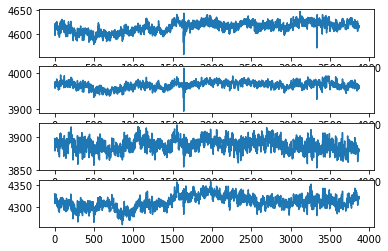

In [6]:
subplot = 0
fig, axs = plt.subplots(4)
for col in df.columns:
    axs[subplot].plot(df[col].values)
    subplot += 1

<h1> Wavlet Decomposition 

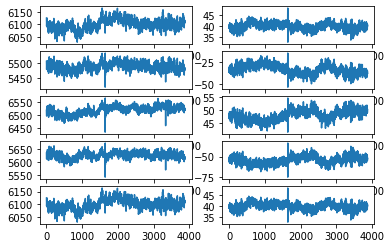

In [7]:
bands = approx.shape[1]
subplot = 0
axis = 0
fig, axs = plt.subplots(bands, 2)
for dataset in [approx, detail]:
    for col in range(bands):
        axs[subplot, axis].plot(dataset[:,col])
        subplot += 1
    subplot = 0
    axis += 1

<h1> PCA Seperating Approx and Discrete

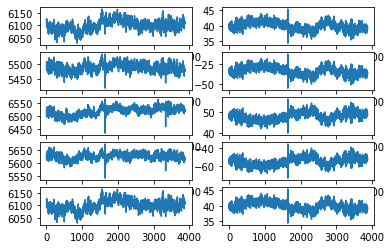

In [8]:
bands = approx.shape[1]
subplot = 0
axis = 0
pca_approx = pca_and_inverse(approx) 
pca_detail = pca_and_inverse(detail)
fig, axs = plt.subplots(bands, 2)
for dataset in [pca_approx, pca_detail]:
    for col in range(bands):
        axs[subplot, axis].plot(dataset[:,col])
        subplot += 1
    subplot = 0
    axis += 1

<h1> PCA

In [9]:
subplot = 0
axis = 0
full = np.concatenate((approx, detail), axis=1)
pca_full = pca_and_inverse(full)
bands = pca_full.shape[1]

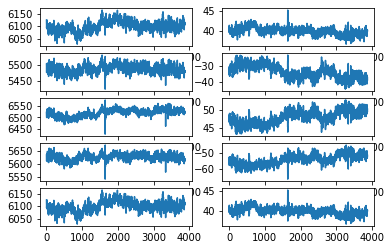

In [10]:
fig, axs = plt.subplots(int(bands / 2), 2)
for col in range(bands):
    axs[subplot, axis].plot(pca_full[:,col])
    subplot += 1
    if subplot == int(bands / 2):
        subplot = 0
        axis += 1

<h1> Training Data

In [11]:
seconds_to_check = 1
interval_range = int(128 * seconds_to_check)
data_points = int(30 / seconds_to_check)

def split_to_training_data(df):
    total_data = []
    for interval_start in range(0, interval_range * data_points, interval_range):
        temp_data = []
        for col in range(0, df.shape[1]):
            temp_data.append(df[interval_start:interval_start + interval_range, col])
        
        total_data.append(temp_data)
        
    return np.asarray(total_data)

def create_target_data(data, target):
    return np.asarray([target] * data.shape[0])

In [16]:
# WAVELET
targets = range(1, 9)
total_train_x = []
total_train_y = []
for target in targets:
    df = trim_cols(load_df('sultan_checkerboard_{}.csv'.format(target)))
    approx, decomp = filter_data(df)
    pca_approx = pca_and_inverse(approx) 
    pca_decomp = pca_and_inverse(decomp)
    filtered_df = np.concatenate((pca_approx, pca_decomp), axis=1)
    filtered_df = pca_approx
    train_x = split_to_training_data(filtered_df)
    train_y = create_target_data(train_x, target - 1)
    if target == 1:
        total_train_x = train_x
        total_train_y = train_y
    else:
        total_train_x = np.concatenate((total_train_x, train_x))
        total_train_y = np.concatenate((total_train_y, train_y))

In [17]:
# NON-WAVELET
# targets = range(1, 9)
# total_train_x = []
# total_train_y = []
# for target in targets:
#     df = trim_cols(load_df('sultan_checkerboard_{}.csv'.format(target)))
#     filtered_df = filter_data(df)
#     train_x = split_to_training_data(filtered_df)
#     train_y = create_target_data(train_x, target - 1)
#     if target == 1:
#         total_train_x = train_x
#         total_train_y = train_y
#     else:
#         total_train_x = np.concatenate((total_train_x, train_x))
#         total_train_y = np.concatenate((total_train_y, train_y))

In [18]:
total_train_x.shape

(240, 5, 128)

In [19]:
train_x, validation_x, train_y, validation_y = train_test_split(total_train_x, total_train_y, test_size = 0.2)